In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import utils as ut

In [2]:
import os
import glob
files = glob.glob('profiles/*.pkl')

out_train = {}
out_val = {}

for i, file in enumerate(files):
    with open(file, 'rb') as f:
        tmp = pickle.load(f)

        if i < 6:
            out_train = {**out_train, **tmp}

        else:
            out_val = {**out_val, **tmp}

nwindows = [10, 100, 1000]
X, y = ut.pickle_to_data(out_train, nwindow=nwindows)
X_val, y_val = ut.pickle_to_data(out_val, nwindow=nwindows)

c:\ProgramData\Anaconda3\lib\site-packages\pandas\core\window\rolling.py:655: RuntimeWarning: All-NaN slice encountered
  return func(x, start, end, min_periods, *numba_args)
c:\ProgramData\Anaconda3\lib\site-packages\pandas\core\window\rolling.py:655: RuntimeWarning: All-NaN slice encountered
  return func(x, start, end, min_periods, *numba_args)
c:\ProgramData\Anaconda3\lib\site-packages\pandas\core\window\rolling.py:655: RuntimeWarning: All-NaN slice encountered
  return func(x, start, end, min_periods, *numba_args)
c:\ProgramData\Anaconda3\lib\site-packages\pandas\core\window\rolling.py:655: RuntimeWarning: All-NaN slice encountered
  return func(x, start, end, min_periods, *numba_args)
c:\ProgramData\Anaconda3\lib\site-packages\pandas\core\window\rolling.py:655: RuntimeWarning: All-NaN slice encountered
  return func(x, start, end, min_periods, *numba_args)
c:\ProgramData\Anaconda3\lib\site-packages\pandas\core\window\rolling.py:655: RuntimeWarning: All-NaN slice encountered
  ret

In [3]:
print(X.shape, y.shape)
print(X_val.shape, y_val.shape)

(441923, 143) (441923, 1)
(376628, 143) (376628, 1)


In [4]:
X.columns

Index(['force_median_mean_rolling_10', 'fmax_mean_rolling_10',
       'L2012_lambda_mean_rolling_10', 'L2012_f0_mean_rolling_10',
       'L2012_delta_mean_rolling_10', 'L2012_L_mean_rolling_10',
       'npeaks_mean_rolling_10', 'B2009_psi_mean_rolling_10',
       'gradient_psi_mean_rolling_10', 'delta_bellaire_mean_rolling_10',
       ...
       'fmax_cumsum', 'L2012_lambda_cumsum', 'L2012_f0_cumsum',
       'L2012_delta_cumsum', 'L2012_L_cumsum', 'npeaks_cumsum',
       'B2009_psi_cumsum', 'gradient_psi_cumsum', 'delta_bellaire_cumsum',
       'delta_bellairef5_cumsum'],
      dtype='object', length=143)

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder


le = LabelEncoder()
X_train, X_test, y_train, y_test = train_test_split(X, le.fit_transform(y.values.reshape(-1)), test_size=0.3, random_state=42069)
clf = XGBClassifier(
    max_depth=5,             # Limit tree depth for better generalization
    min_child_weight=5,      # Minimum sum of instance weight (hessian) needed in a child
    reg_alpha=1,             # L1 regularization term on weights
    reg_lambda=1,            # L2 regularization term on weights
    subsample=0.8,           # Subsample ratio of the training instances
    colsample_bytree=0.8,    # Subsample ratio of columns when constructing each tree
    learning_rate=0.05,      # Lower learning rate for slower, more controlled training
    n_estimators=100         # Number of trees in the model
)
clf.fit(X_train, y_train)

[22:38:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=5,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=1, ...)

In [13]:
from sklearn.metrics import f1_score, accuracy_score

# how does the model fare?
train_score = f1_score(y_train, clf.predict(X_train), average='weighted')
test_score = f1_score(y_test, clf.predict(X_test), average='weighted')
val_score = f1_score(le.transform(y_val), clf.predict(X_val), average='weighted')

print(f'training f1 score is {train_score:.2f}')
print(f'testing f1 score is {test_score:.2f}')
print(f'val f1 score is {val_score:.2f}')

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


training f1 score is 0.98
testing f1 score is 0.98
val f1 score is 0.83


The training and testing score are too good to be true! Let's look at a few profiles that were used in the training set for understanding.

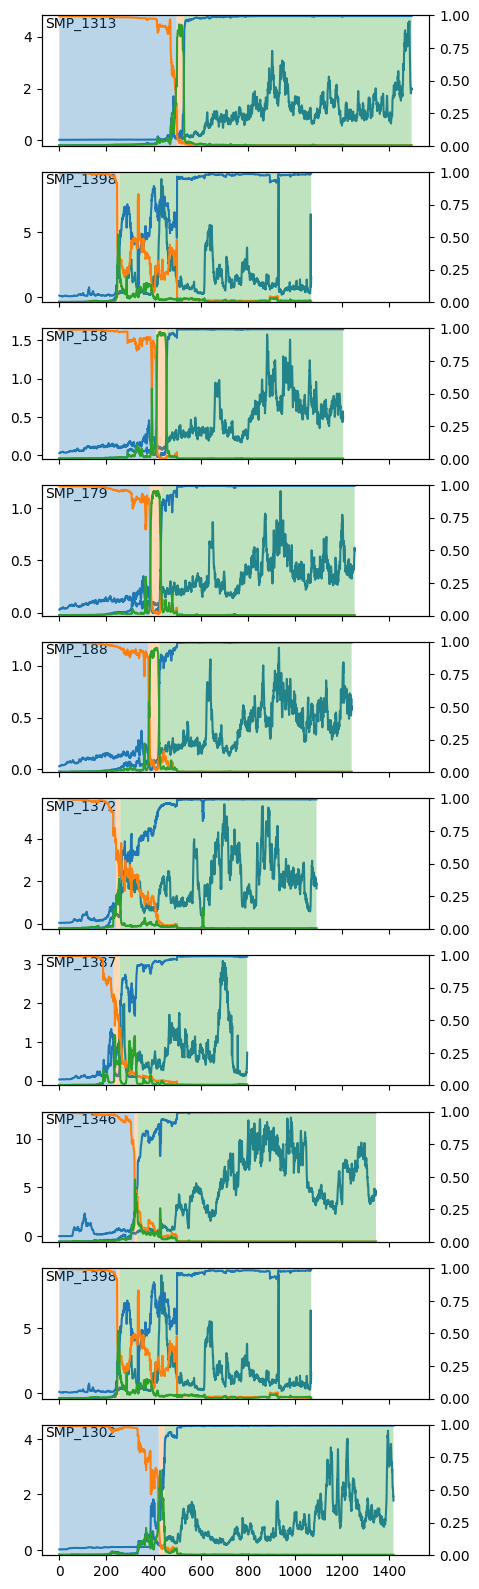

In [22]:
nsamples = 10
keys = list(out_train.keys())
keys = np.random.choice(keys, nsamples)

fig, axs = plt.subplots(nsamples, 1, sharex='all', figsize=(5, 2 * nsamples))
for i, key in enumerate(keys):

    profile = out_train[key]

    if 'layer' not in profile.columns:
        continue

    xi, yi = ut.profile_to_df(profile)
    xi = ut.process_df_for_ensemble(xi, nwindow=nwindows)
    yi_hat = clf.predict_proba(xi)


    ax = axs[i]
    ax.text(0.01, 0.99, key, ha='left', va='top', transform=ax.transAxes)
    ax.plot(profile['distance'], profile['force_median'])

    ax2 = ax.twinx()
    for i, layer in enumerate(yi.unique()):
        ax2.fill_between(profile['distance'], yi == layer, 0, zorder=0, alpha=0.3)
        ax2.plot(profile['distance'], yi_hat[:, i])

    ax2.set_ylim(0, 1.0)

What about validation profiles?

In [20]:
%matplotlib qt
nsamples = 10
keys = list(out_val.keys())
keys = np.random.choice(keys, nsamples)

fig, axs = plt.subplots(nsamples, 1, sharex='all', figsize=(5, 2 * nsamples))
for i, key in enumerate(keys):

    profile = out_val[key]

    if 'layer' not in profile.columns:
        continue

    xi, yi = ut.profile_to_df(profile)
    xi = ut.process_df_for_ensemble(xi, nwindow=nwindows)
    yi_hat = clf.predict_proba(xi)[:, 1]

    ax = axs[i]
    ax.text(0.01, 0.99, key, ha='left', va='top', transform=ax.transAxes)
    ax.plot(profile['distance'], profile['force_median'])
    ax2 = ax.twinx()
    ax2.fill_between(profile['distance'], 0, yi, fc='tab:red', alpha=0.6)
    ax2.plot(profile['distance'], yi_hat, c='k')
    ax2.set_ylim(0, 1.05)

0.09695936855323346

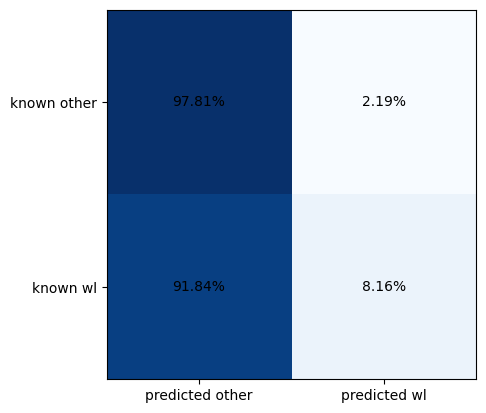

In [67]:
# the model picks the weak layer correctly, but it is probably uneable to generalize for now. let's look at the confusion matrix
from sklearn.metrics import confusion_matrix, f1_score

confmat = confusion_matrix(y_val, clf.predict(X_val), normalize='true')

fig, ax = plt.subplots()
ax.imshow(confmat, cmap='Blues')
ticks = np.arange(len(y.iloc[:, 0].unique()))
ax.set_xticks(ticks)
ax.set_yticks(ticks)

ax.set_yticklabels(['known other', 'known wl'])
ax.set_xticklabels(['predicted other', 'predicted wl'])

for i in ticks:
    for j in ticks:
        ax.text(j, i, f'{100 * confmat[i, j]:.2f}%', ha='center', va='center')

f1 = f1_score(y_val, clf.predict(X_val))
f1

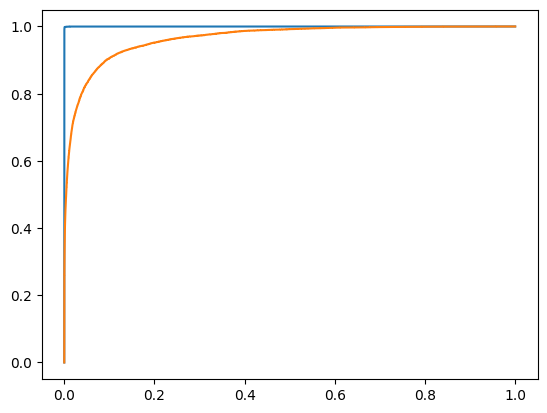

In [64]:
from sklearn.metrics import roc_curve
roc_train = roc_curve(y_train, clf.predict_proba(X_train)[:, 1])
roc_val = roc_curve(y_val, clf.predict_proba(X_val)[:, 1])
plt.plot(roc_train[0], roc_train[1])
plt.plot(roc_val[0], roc_val[1])

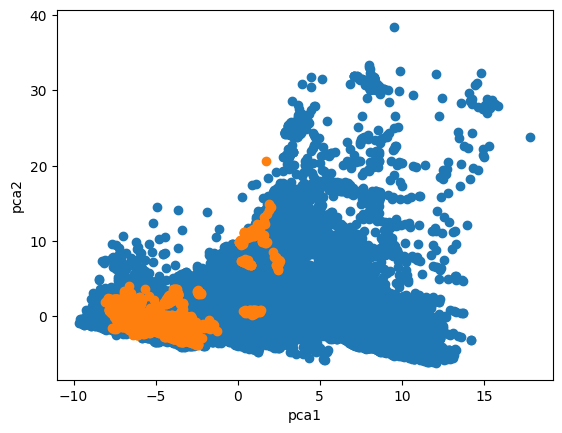

In [37]:
Z_train = pipe.transform(X_train)

isweak = y_train.astype(bool).reshape(-1)
plt.scatter(Z_train[~isweak, 0], Z_train[~isweak, 1])
plt.scatter(Z_train[isweak, 0], Z_train[isweak, 1])

plt.xlabel('pca1')
plt.ylabel('pca2')

xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()

(-17.824803321897626, 30.647273486248974)

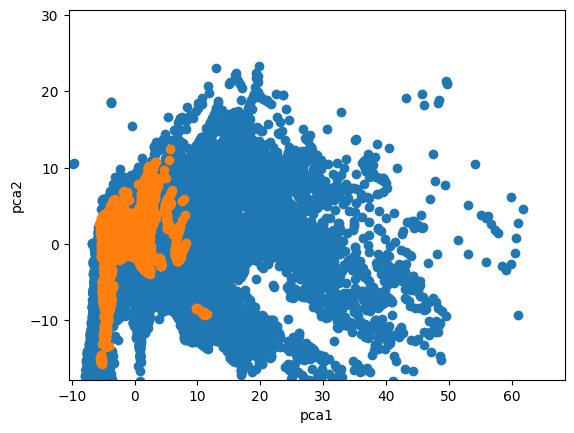

In [60]:
Z_val = pipe.transform(X_val)

isweak = y_val.astype(bool).values.reshape(-1)
plt.scatter(Z_val[~isweak, 0], Z_val[~isweak, 1])
plt.scatter(Z_val[isweak, 0], Z_val[isweak, 1])

plt.xlabel('pca1')
plt.ylabel('pca2')

plt.xlim(xlim)
plt.ylim(ylim)
